# Image classification with Celebrity Faces dataset

## Environment setup

In [1]:
# Force no warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import os
from pathlib import Path
from functools import partial

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Suppress INFO and WARNING messages in TensorFlow
#os.environ["CUDA_VISIBLE_DEVICES"] = "1" # Force TensorFlow to use your GPU1 (NVidia GPU)

In [2]:
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array, array_to_img, save_img
from keras.utils import set_random_seed
from keras.layers import Input, Resizing, RandomRotation, RandomShear, RandomFlip
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.layers import Activation, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

In [ ]:
# Some utility variables used throughout this experiment
rs = 147 # Random state for repeatability
img_root = "../../data/Celebrity Faces Dataset"
labels = [
    "Angelina Jolie", "Kate Winslet", "Natalie Portman", "Nicole Kidman", "Sandra Bullock",
    "Brad Pitt", "Johnny Depp", "Leonardo DiCaprio", "Tom Cruise", "Tom Hanks"
]
label_map = { labels[idx]: idx for idx in range(len(labels)) }
label_col = "img_label" # Target column name in temporary DataFrame
new_size = (200, 200) # Final image size for preprocessing (MUST be reduced if out of memory)

set_random_seed(rs)

## Utility functions

In [ ]:
def images_as_dataframe(img_root, class_names=None):
    rows = []
    for root, dirs, files in os.walk(img_root, topdown=False):
        if len(files):
            img_label = os.path.split(root)[-1]
            if class_names and img_label in class_names:
                for file in files:
                    row = {
                        "img_path": str(Path(f"/{img_label}") / file),
                        "img_label": img_label
                    }
                    rows.append(pd.Series(row))

    return pd.DataFrame(rows)

In [ ]:
def train_val_test_split(df, target):
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a Pandas DataFrame object.")

    X = df.drop(target, axis=1)
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=rs)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=50, stratify=y_train, random_state=rs)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [ ]:
def aggregate_images(img_root, df, size):
    all_img = []
    for img in df["img_path"]:
        img_path = img_root + img

        # Load image as Numpy array using Keras utilities
        image = load_img(img_path)
        image_arr = img_to_array(image)

        # Resize image to given size using Keras Resizing layer
        in_layer = Input(shape=image_arr.shape)
        res_layer = Resizing(size[0], size[1])(in_layer)
        model = Model(inputs=in_layer, outputs=res_layer)
        res_arr = model(np.array([image_arr])) # Make a single-item batch from original image (i.e., convert 3D tensor to 4D)
        res_arr = res_arr.numpy().reshape((size[0], size[1], 3)) # Convert 4D tensor to 3D numpy array
        all_img.append(res_arr)

    # Return resulting list as an image batch
    return np.array(all_img)

In [ ]:
def prepare_data(img_root, X, y, size):
    X_prep = aggregate_images(img_root, X, size)
    y_prep = [label_map[label] for label in y]
    y_prep = np.array(y_prep)

    return X_prep, y_prep

In [ ]:
def get_model(in_shape):
    DefaultConv2D = partial(Conv2D, kernel_size=3, padding="same",
                           activation="relu", kernel_initializer="he_normal")
    model = Sequential([
        Input(shape=in_shape),
        DefaultConv2D(filters=64, kernel_size=5),
        MaxPool2D(),
        DefaultConv2D(filters=128),
#        DefaultConv2D(filters=128),
        MaxPool2D(),
        DefaultConv2D(filters=256),
#        DefaultConv2D(filters=256),
        MaxPool2D(),
        Flatten(),
        Dense(units=128, activation="relu", kernel_initializer="he_normal"),
        Dropout(0.5),
        Dense(units=64, activation="relu", kernel_initializer="he_normal"),
        Dropout(0.5),
        Dense(units=10, activation="softmax")
    ])

    return model

## Data preparation

In [ ]:
# Make a temporary DataFrame from dataset images
df_images = images_as_dataframe(img_root, labels)
df_images.sample(10, random_state=rs)

In [ ]:
# Split temporary DataFrame to train/test/validation sets (for later preprocessing)
(X_train, y_train), (X_val, y_val), (X_test, y_test) = train_val_test_split(df_images, label_col)

print(f"Train shape - X : {X_train.shape}\ty : {y_train.shape}")
print(f"Val shape   - X : {X_val.shape}\ty : {y_val.shape}")
print(f"Test shape  - X : {X_test.shape}\ty : {y_test.shape}")

In [ ]:
# Resize images in train/validation/test datasets and encode class labels
X_train, y_train = prepare_data(img_root, X_train, y_train, new_size)

In [ ]:
X_val, y_val = prepare_data(img_root, X_val, y_val, new_size)

In [ ]:
X_test, y_test = prepare_data(img_root, X_test, y_test, new_size)

In [ ]:
print(f"Train shape - X : {X_train.shape}\ty : {y_train.shape}")
print(f"Val shape   - X : {X_val.shape}\ty : {y_val.shape}")
print(f"Test shape  - X : {X_test.shape}\ty : {y_test.shape}")

In [ ]:
# Save validation and test sets to compressed Numpy files (.npz)
np.savez_compressed("test.npz", x_test=X_test, y_test=y_test, allow_pickle=False)
np.savez_compressed("validation.npz", x_val=X_val, y_val=y_val, allow_pickle=False)

In [ ]:
# Preview a sample image
plt.imshow(X_test[7].astype(np.uint8))
plt.axis("off")

In [ ]:
X_train.dtype

## Training a basic CNN on a small training data

In [ ]:
model = get_model(X_train.shape[1:])
model.summary()

In [ ]:
optimizer = SGD(learning_rate=0.003)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
y_train_q = y_train.astype(np.int8)
y_val_q = y_val.astype(np.int8)
X_train_s, X_val_s = X_train / 255.0, X_val / 255.0

In [ ]:
history = model.fit(X_train_s, y_train_q, batch_size=1, epochs=30, validation_data=(X_val_s, y_val_q))

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5), xlim=[0, 29], ylim=[0, 1],
                                   grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.show()

## Using our data pipeline (from ML package)

In [3]:
import sys

# Make our package modules visible in this notebook
proj_root = os.path.dirname(os.getcwd())
path = Path(proj_root) / "src"
sys.path.append(str(path))

from celebrity_faces.pipeline import pipeline
from celebrity_faces.config import config

I0000 00:00:1767386842.131409  181256 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1353 MB memory:  -> device: 0, name: NVIDIA GeForce MX570 A, pci bus id: 0000:01:00.0, compute capability: 8.6


### Training a tiny CNN (validation)

The main goal here is to validate our data pipeline, as suggested by ChatGPT.

In [ ]:
def test_model(in_shape):
    DefaultConv2D = partial(Conv2D, kernel_size=3, padding="same", kernel_initializer="he_normal")

    model = Sequential([
        Input(shape=in_shape),
        DefaultConv2D(filters=64, kernel_size=5),
        BatchNormalization(),
        Activation("relu"),
        MaxPool2D(),
        DefaultConv2D(filters=128),
        BatchNormalization(),
        Activation("relu"),
        GlobalAveragePooling2D(),
        Dense(units=128, activation="relu", kernel_initializer="he_normal"),
        Dense(units=10, activation="softmax")
    ])

    return model

In [ ]:
input_shape = (160, 160, 3)

model = test_model(input_shape)
model.summary()

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
history = model.fit(
    pipeline.train_ds, batch_size=config.BATCH_SIZE, epochs=15, validation_data=pipeline.val_ds
)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5), xlim=[0, 14], ylim=[0, 4],
                                   grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.show()

### Training a baseline model

In [ ]:
def baseline_model(in_shape):
    DefaultConv2D = partial(Conv2D, kernel_size=3, padding="same", kernel_initializer="he_normal")

    model = Sequential([
        Input(shape=in_shape),

        # Conv2D layer #1
        DefaultConv2D(filters=128, kernel_size=5),
        BatchNormalization(),
        Activation("relu"),
        MaxPool2D(),

        # Conv2D layer #2
        DefaultConv2D(filters=256, kernel_size=5),
        BatchNormalization(),
        Activation("relu"),
        MaxPool2D(),

        # Conv2D layer #3
        DefaultConv2D(filters=256),
        BatchNormalization(),
        Activation("relu"),
        MaxPool2D(),

        # Conv2D layer #4
        DefaultConv2D(filters=512),
        BatchNormalization(),
        Activation("relu"),
        GlobalAveragePooling2D(),

        Dense(units=512, activation="relu", kernel_initializer="he_normal"),
        Dropout(0.4),
        Dense(units=128, activation="relu", kernel_initializer="he_normal"),
        Dropout(0.4),
        Dense(units=10, activation="softmax")
    ])

    return model

In [ ]:
input_shape = config.IMAGE_SIZE + (3,)

model = baseline_model(input_shape)
model.summary()

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# Setup callbacks
checkpoint_cb = ModelCheckpoint(
    "./keras_ckpt/test.weights.h5", monitor="val_accuracy",
    save_best_only=True, save_weights_only=True
)

early_stopping_cb = EarlyStopping(
    monitor="val_accuracy", min_delta=0.05, patience=5,
    restore_best_weights=True, start_from_epoch=10
)

In [ ]:
history = model.fit(
    pipeline.train_ds, batch_size=config.BATCH_SIZE, epochs=50,
    validation_data=pipeline.val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5), xlim=[0, 19], ylim=[0, 5],
                                   grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.show()

### Several flaws in my wrong model

*TODO: Summarize bad design choices, as well as common tips and guidelines, as explained by ChatGPT.*

### Training a better baseline model

In [4]:
def better_model(in_shape):
    DefaultConv2D = partial(Conv2D, kernel_size=3, padding="same", kernel_initializer="he_normal")

    model = Sequential([
        Input(shape=in_shape),

        # Conv2D layer #1
        DefaultConv2D(filters=32),
        BatchNormalization(),
        Activation("relu"),
        MaxPool2D(),

        # Conv2D layer #2
        DefaultConv2D(filters=64),
        BatchNormalization(),
        Activation("relu"),
        MaxPool2D(),

        # Conv2D layer #3
        DefaultConv2D(filters=128),
        BatchNormalization(),
        Activation("relu"),
        MaxPool2D(),

        # Conv2D layer #4
        DefaultConv2D(filters=256),
        BatchNormalization(),
        Activation("relu"),
        GlobalAveragePooling2D(),

        Dense(units=64, activation="relu", kernel_initializer="he_normal"),
        Dropout(0.2),
        Dense(units=10, activation="softmax")
    ])

    return model

In [5]:
input_shape = config.IMAGE_SIZE + (3,)
model = better_model(input_shape)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 20, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 20, 20, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,434 (1.55 MB)

 Trainable params: 406,474 (1.55 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
# Setup callbacks
checkpoint_cb = ModelCheckpoint(
    "./keras_ckpt/test.weights.h5", monitor="val_loss",
    save_best_only=True, save_weights_only=True
)

early_stopping_cb = EarlyStopping(
    monitor="val_loss", min_delta=0.001, patience=8,
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    pipeline.train_ds, batch_size=config.BATCH_SIZE, epochs=50,
    validation_data=pipeline.val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5), xlim=[0, 11], ylim=[0, 5],
                                   grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.show()

### Quick checks suggested by ChatGPT

**Make sure validation data has NOT been augmented**

*Note: I double-checked, and this is NOT happening in my pipeline.*

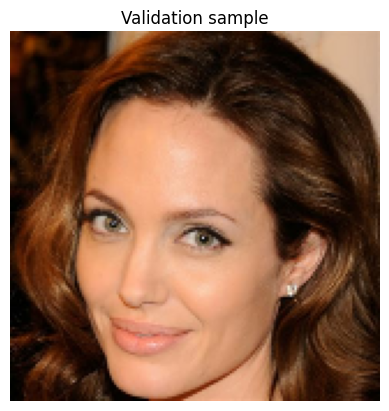

In [5]:
for images, _ in pipeline.val_ds.take(1):
    plt.imshow(images[7])
    plt.title("Validation sample")
    plt.axis("off")

**Make sure model overfits a tiny subset**

In [9]:
input_shape = config.IMAGE_SIZE + (3,)
small_train_ds = pipeline.train_ds.take(5)  # ~40 images

model = better_model(input_shape)
model.compile(
    optimizer=Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(small_train_ds, epochs=50)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.0533 - loss: 2.5614

I0000 00:00:1767378200.068088  143636 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 41ms/step - accuracy: 0.1000 - loss: 2.5101
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2000 - loss: 2.4070
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2000 - loss: 2.2897
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1750 - loss: 2.2989
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2250 - loss: 2.1525
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1500 - loss: 2.2642
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3000 - loss: 2.0527
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2000 - loss: 2.2542
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2000 - loss: 2.1821
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1750 - loss: 2.2320
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.1250 - loss: 2.4246
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2750 - loss: 2.0879
Epoch 13/50


There is *definitely* a problem here! We should have reached 100% train accuracy (according to ChatGPT).

**Make sure there's no label-class mismatch**

In [8]:
print(pipeline.train_labels)
print(pipeline.val_labels)
print(pipeline.test_labels)

['Angelina Jolie', 'Brad Pitt', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Natalie Portman', 'Nicole Kidman', 'Sandra Bullock', 'Tom Cruise', 'Tom Hanks']
['Angelina Jolie', 'Brad Pitt', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Natalie Portman', 'Nicole Kidman', 'Sandra Bullock', 'Tom Cruise', 'Tom Hanks']
['Angelina Jolie', 'Brad Pitt', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Natalie Portman', 'Nicole Kidman', 'Sandra Bullock', 'Tom Cruise', 'Tom Hanks']


### Final fix : cache *before* augmentation

Quick notes :

1. After reading technical explanation, it makes perfect sense that stochastic data (random rotation and flip) should **NOT** be cached.
2. I was misguided by ChatGPT! It explicitly named augmentation "step 2" and optimization (cache + shuffle + prefetch) "step 3".
3. I know perfectly well I should double-check AI agent instructions, but I was bitten by my lack of CNN experience!

## Training with a fixed pipeline

In [7]:
input_shape = config.IMAGE_SIZE + (3,)
small_train_ds = pipeline.train_ds.take(5)  # ~40 images

model = better_model(input_shape)
model.compile(
    optimizer=Adam(0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(small_train_ds, epochs=30)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1304 - loss: 2.2946

I0000 00:00:1767382533.917437  163019 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.1000 - loss: 2.3673
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1000 - loss: 2.6613
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1000 - loss: 2.3337
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2250 - loss: 2.2426
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3250 - loss: 2.1094
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1500 - loss: 2.3066
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3250 - loss: 2.1211
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1500 - loss: 2.1917
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2500 - loss: 2.2345
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.0750 - loss: 2.3691
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1250 - loss: 2.4083
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1750 - loss: 2.1709
Epoch 13/30


### 15% accuracy??? Really?

As it turns out (ONLY if ChatGPT was correct) there is another flaw in this "overfitting" sanity check.
This check must be done with raw data and zero randomness (i.e. NO batch normalization, NO data augmentation
and NO dropout!) This is due to some advanced math logic, which I'm not going to elaborate on here.

So let's move on to some debugging...

**Step 1 : Create a BN-free debug model**

In [4]:
def debug_model(in_shape):
    DefaultConv2D = partial(
        Conv2D, kernel_size=3, padding="same", kernel_initializer="he_normal"
    )

    return Sequential([
        Input(shape=in_shape),

        DefaultConv2D(32), Activation("relu"), MaxPool2D(),
        DefaultConv2D(64), Activation("relu"), MaxPool2D(),
        DefaultConv2D(128), Activation("relu"),

        GlobalAveragePooling2D(),
        Dense(64, activation="relu"),
        Dense(10, activation="softmax")
    ])

**Step 2 : Disable augmentation for the test**

*Note: I temporarily did this in original pipeline and refreshed my package imports.*

**Step 3 : Run the sanity test properly**

In [5]:
small_train_ds = pipeline.train_ds.take(5)

model = debug_model((160, 160, 3))
model.compile(
    optimizer=Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.fit(small_train_ds, epochs=30)

Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.1000 - loss: 2.4470
Epoch 2/30


I0000 00:00:1767386901.344094  181388 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.0250 - loss: 2.3469
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1000 - loss: 2.2571
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1500 - loss: 2.2754
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1000 - loss: 2.2417
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2000 - loss: 2.2377
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1500 - loss: 2.2290
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2000 - loss: 2.1185
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0500 - loss: 2.3202
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3250 - loss: 2.2278
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2000 - loss: 2.2338
Epoch 12/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2250 - loss: 2.1718
Epoch 13/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1500 - loss: 2.1779
Epoch 14/30

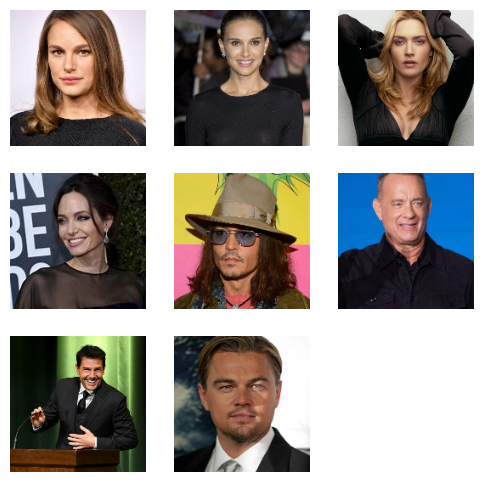

In [10]:
for imgs, _ in pipeline.train_ds.take(1):
    plt.figure(figsize=(6,6))
    for i in range(8):
        plt.subplot(3,3,i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
    plt.show()